In [1]:
import tensorflow as tf
import polars as pl
import numpy as np
import IPython
import matplotlib.pyplot as plt
import seaborn as sns

import utils
from window_generator import WindowGenerator

2023-04-10 23:38:40.692429: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 23:38:40.742525: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 23:38:40.743508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 23:38:41.841970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pl.read_csv("../data/prices/F_prices.csv")

# clean data
df.drop_in_place('Date')

# split data
train_df, val_df, test_df = utils.split_train_val_test(df, .7, .2)

# normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = train_df.with_columns([
    (pl.col(label) - train_mean[label]) / train_std[label] for label in train_mean.columns
])

val_df = val_df.with_columns([
    (pl.col(label) - train_mean[label]) / train_std[label] for label in train_mean.columns
])

test_df = test_df.with_columns([
    (pl.col(label) - train_mean[label]) / train_std[label] for label in train_mean.columns
])


[Text(0, 0, 'Price'), Text(1, 0, 'Volume')]

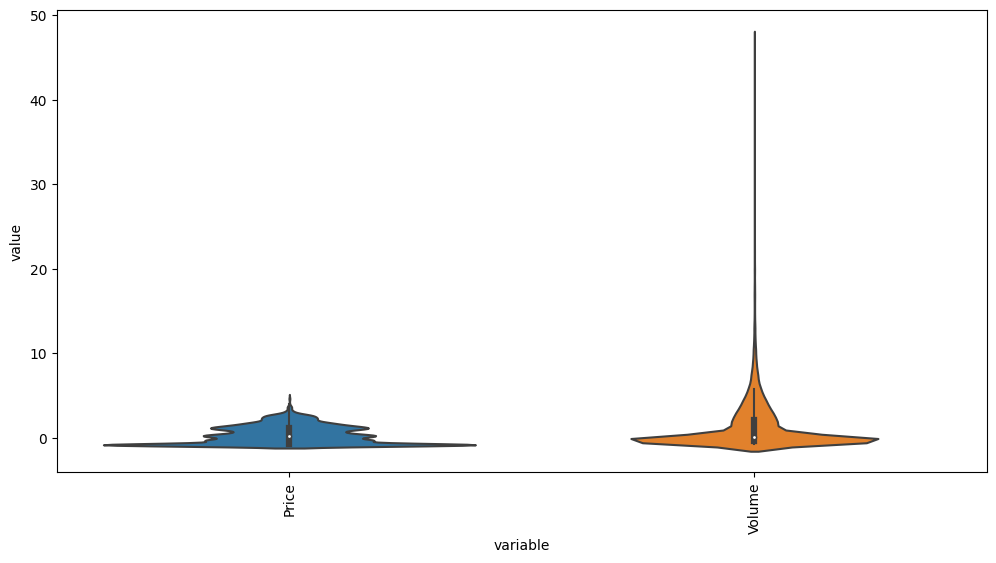

In [3]:
df_std = df.with_columns([
    (pl.col(label) - train_mean[label]) / train_std[label] for label in train_mean.columns
])
df_std = df_std.melt(value_vars=df_std.columns)
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='variable', y='value', data=df_std.to_pandas())
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)

In [4]:
window = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['Price'], train_df=train_df, val_df=val_df, test_df=test_df)

window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Price']

In [5]:
example_window = tf.stack([train_df[:window.total_window_size].to_numpy(),
                           train_df[100:100+window.total_window_size].to_numpy(),
                           train_df[200:200+window.total_window_size].to_numpy()])
# print(train_df)
# print(example_window)
# print(example_window.shape)
example_inputs, example_labels = window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
inside tf.Tensor(
[[[-0.85278127 -0.18625271]]

 [[-0.84957956 -0.63221694]]

 [[-0.85092794 -0.60403638]]], shape=(3, 1, 2), dtype=float64)
tf.Tensor(
[[[-0.85278127]]

 [[-0.84957956]]

 [[-0.85092794]]], shape=(3, 1, 1), dtype=float64)
All shapes are: (batch, time, features)
Window shape: (3, 7, 2)
Inputs shape: (3, 6, 2)
Labels shape: (3, 1, 1)


2023-04-10 23:38:44.723438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-10 23:38:44.724373: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [7]:
print('Input shape:', window.example[0].shape)
print('Output shape:', lstm_model(window.example[0]).shape)


<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>
inside Tensor("strided_slice_1:0", shape=(None, None, 2), dtype=float64)
Tensor("stack:0", shape=(None, None, 1), dtype=float64)
Input shape: (32, 6, 2)


2023-04-10 23:38:45.124424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [8967]
	 [[{{node Placeholder/_8}}]]
2023-04-10 23:38:45.124774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [8967]
	 [[{{node Placeholder/_8}}]]


Output shape: (32, 6, 1)


2023-04-10 23:38:45.654045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-10 23:38:45.656914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-10 23:38:45.659762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [8]:
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')

history = lstm_model.fit(window.train, epochs=20,
                         validation_data=window.val,
                         callbacks=[early_stopping])

<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>
inside Tensor("strided_slice_1:0", shape=(None, None, 2), dtype=float64)
Tensor("stack:0", shape=(None, None, 1), dtype=float64)
<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>
inside Tensor("strided_slice_1:0", shape=(None, None, 2), dtype=float64)
Tensor("stack:0", shape=(None, None, 1), dtype=float64)
Epoch 1/20


2023-04-10 23:38:46.091301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-10 23:38:46.091644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8973,2]
	 [[{{node Placeholder/_0}}]]
2023-04-10 23:38:46.384862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int

276/281 [============================>.] - ETA: 0s - loss: 0.2146 - mean_absolute_error: 0.2826

2023-04-10 23:38:50.785444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2564,2]
	 [[{{node Placeholder/_0}}]]
2023-04-10 23:38:50.786196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2558]
	 [[{{node Placeholder/_8}}]]
2023-04-10 23:38:51.118849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim'

281/281 [==============================] - 5s 9ms/step - loss: 0.2123 - mean_absolute_error: 0.2805 - val_loss: 0.1729 - val_mean_absolute_error: 0.2943
Epoch 2/20
281/281 [==============================] - 2s 7ms/step - loss: 0.0308 - mean_absolute_error: 0.0960 - val_loss: 0.0919 - val_mean_absolute_error: 0.2087
Epoch 3/20
281/281 [==============================] - 2s 7ms/step - loss: 0.0070 - mean_absolute_error: 0.0526 - val_loss: 0.0561 - val_mean_absolute_error: 0.1548
Epoch 4/20
281/281 [==============================] - 2s 6ms/step - loss: 0.0040 - mean_absolute_error: 0.0386 - val_loss: 0.0401 - val_mean_absolute_error: 0.1268
Epoch 5/20
281/281 [==============================] - 2s 6ms/step - loss: 0.0034 - mean_absolute_error: 0.0328 - val_loss: 0.0330 - val_mean_absolute_error: 0.1142
Epoch 6/20
281/281 [==============================] - 2s 6ms/step - loss: 0.0032 - mean_absolute_error: 0.0308 - val_loss: 0.0274 - val_mean_absolute_error: 0.1056
Epoch 7/20
281/281 [=======

In [10]:
IPython.display.clear_output()
val_performance_lstm = lstm_model.evaluate(window.val)
performance_lstm = lstm_model.evaluate(window.test, verbose=0)

<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>
inside Tensor("strided_slice_1:0", shape=(None, None, 2), dtype=float64)
Tensor("stack:0", shape=(None, None, 1), dtype=float64)
31/80 [==========>...................] - ETA: 0s - loss: 0.0225 - mean_absolute_error: 0.0995

2023-04-10 23:39:06.182927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-04-10 23:39:06.183296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [2558]
	 [[{{node Placeholder/_8}}]]


80/80 [==============================] - 0s 3ms/step - loss: 0.0221 - mean_absolute_error: 0.0969
<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>
inside Tensor("strided_slice_1:0", shape=(None, None, 2), dtype=float64)
Tensor("stack:0", shape=(None, None, 1), dtype=float64)


2023-04-10 23:39:06.586734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1282,2]
	 [[{{node Placeholder/_0}}]]
2023-04-10 23:39:06.587134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]


ValueError: x and y must be the same size

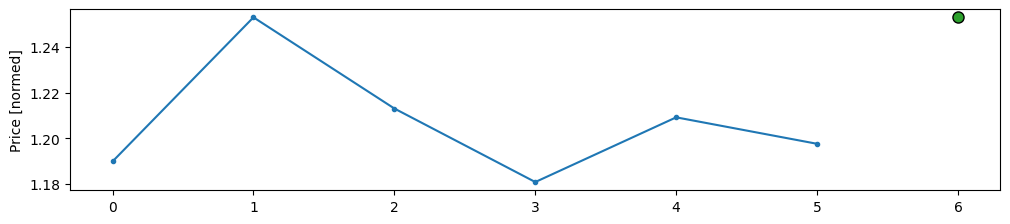

In [11]:
window.plot(lstm_model)